# Value at Risk (VaR) using Monte Carlo Simulation

Import necessary libraries. 

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

## Implementation

### Set Time from to a certain number of years. 

In [2]:
years = 15

# Today's date
end_date = dt.datetime.now()

# 15 years ago from today
start_date = end_date - dt.timedelta(days=365 * years)

In [3]:
print(f'End Date: {end_date}')
print(f'Start Date: {end_date}')

End Date: 2025-09-29 19:40:32.145953
Start Date: 2025-09-29 19:40:32.145953


Create a List of Tickers

In [4]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

### Download the daily **adjusted close prices** for the tickers. 

**Adjusted Closed Prices**: Dividends stock splits, which makes our analysis more accurate. 

In [5]:
adj_close_df = pd.DataFrame()

for ticker in tickers: 
    data = yf.download(ticker, start=start_date, end=end_date)

    if 'Close' in data.columns: 
        adj_close_df[ticker] = data['Close']

/tmp/ipykernel_1144/3270788488.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1144/3270788488.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1144/3270788488.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1144/3270788488.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1144/

In [6]:
print(adj_close_df.head())
print(adj_close_df.tail())

                  SPY        BND         GLD        QQQ        VTI
Date                                                              
2010-10-04  86.818939  53.810345  128.460007  42.493675  44.688938
2010-10-05  88.566811  53.823414  130.990005  43.527973  45.619469
2010-10-06  88.559166  53.947197  131.809998  43.151073  45.573334
2010-10-07  88.452293  54.038429  130.369995  43.308838  45.511814
2010-10-08  88.948402  53.973267  131.660004  43.606838  45.819435
                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2025-09-23  663.210022  74.440002  346.459991  598.200012  328.089996
2025-09-24  661.099976  74.290001  343.320007  596.099976  326.890015
2025-09-25  658.049988  74.209999  344.750000  593.530029  325.140015
2025-09-26  661.820007  74.209999  346.739990  595.969971  327.179993
2025-09-29  663.679993  74.400002  352.459991  598.729980  327.100006


### Calculate the daily log returns and drop any NAs. 

Log returns are additive. 

In [7]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

# Drop the first row with NaN values
log_returns = log_returns.dropna()

In [8]:
print(log_returns.head())
print(log_returns.tail())

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2010-10-05  0.019932  0.000243  0.019503  0.024049  0.020609
2010-10-06 -0.000086  0.002297  0.006240 -0.008696 -0.001012
2010-10-07 -0.001208  0.001690 -0.010985  0.003649 -0.001351
2010-10-08  0.005593 -0.001207  0.009846  0.006857  0.006736
2010-10-11  0.000943 -0.000362  0.004774  0.000402  0.001509
                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2025-09-23 -0.005458  0.002017  0.004078 -0.006664 -0.005380
2025-09-24 -0.003187 -0.002017 -0.009104 -0.003517 -0.003664
2025-09-25 -0.004624 -0.001077  0.004157 -0.004321 -0.005368
2025-09-26  0.005713  0.000000  0.005756  0.004102  0.006255
2025-09-29  0.002806  0.002557  0.016362  0.004620 -0.000245


### Create a function that will be used to calculate portfolio expected return

To clarify, we are assuming that future returns are based on past returns, which is not a reliable assumption. 

**Better approach**: use my own expected returns. 

In [9]:
def expected_return(weights, log_returns): 
    return np.sum(log_returns.mean() * weights)

### Create a function that will be used to calculate portfolio standarad deviation

`cov_matrix`: Consists of the corelation of every single stock in the portfolio. 

In [10]:
def standard_deviation(weights, cov_matrix): 
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

### Create a covariance matrix for all the securities

In [11]:
cov_matrix = log_returns.cov()

In [12]:
print(cov_matrix)

              SPY           BND       GLD       QQQ       VTI
SPY  1.173452e-04  9.562811e-07  0.000005  0.000132  0.000120
BND  9.562811e-07  9.618360e-06  0.000009  0.000002  0.000001
GLD  4.904801e-06  9.213237e-06  0.000097  0.000006  0.000005
QQQ  1.315544e-04  1.734299e-06  0.000006  0.000170  0.000134
VTI  1.195038e-04  1.169660e-06  0.000005  0.000134  0.000123


### Create an equally weighted portfolio and find total portfolio expected return and standard deviation

In [13]:
portfolio_value = 1000000
weights = np.array([1 / len(tickers)] * len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation(weights, cov_matrix)

In [14]:
print(f'Expected Return: {portfolio_expected_return: .2f}')
print(f'Standard Deviation: {portfolio_std_dev: .2f}')

Expected Return:  0.00
Standard Deviation:  0.01


### Create a funcion that gives a random Z-score based on normally distribution

In [15]:
def random_z_score(): 
    return np.random.normal(0, 1)

### Create a function to calculate scenarioGainLoss

In [16]:
days = 5

def scenario_gain_loss(portfolio_value, portfolio_std_dev, portfolio_expected_return, z_score, days): 
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

### Run 10000 simulations

In [17]:
simulations = 10000
scenario_return = []

for i in range(simulations): 
    z_score = random_z_score()
    scenario_return.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, portfolio_expected_return, z_score, days))

In [18]:
print(f'Examples of Scenario Returns: {scenario_return[:5]}')

Examples of Scenario Returns: [-14202.018801916583, 29865.316466435965, -2873.741536557982, 9670.988829576127, 2807.7527469379975]


### Specify a confidence interval and calculate the VaR

In [19]:
confidence_level = 0.95
VaR = (-1) * np.percentile(scenario_return, 100 * (1 - confidence_level))

In [20]:
print(f'VaR: {VaR}')

VaR: 25123.116737624012


### Plot the results of all 10000 scenarios

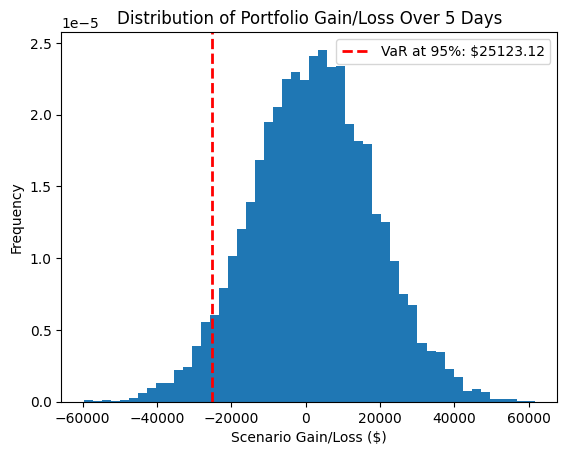

In [21]:
plt.hist(scenario_return, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(x=-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {int(confidence_level*100)}%: ${VaR:.2f}')
plt.legend()
plt.show()

## Integration

Now we integrate the whole process into a class so that we can call it given different parameters. 

In [22]:
def download_prices(past_years, tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']): 
    """
    Download prices data from Yahoo given a specified number of past years.
    """
    df = pd.DataFrame()

    # Today's date
    end_date = dt.datetime.now()

    # 15 years ago from today
    start_date = end_date - dt.timedelta(days=365 * past_years)
    
    for ticker in tickers: 
        data = yf.download(ticker, start=start_date, end=end_date, actions=True)
        prices = data['Close']
        divs = data['Dividends']

        # Daily returns including dividends
        returns = prices.pct_change().fillna(0) + (divs / prices.shift(1)).fillna(0)

        # Rebuild cumulative adjusted price
        adj_prices = (1 + returns).cumprod() * prices.iloc[0]

        df[ticker] = adj_prices

    print('Prices Download Complete! \n')

    return df

class VaRMonteCarlo: 
    def __init__(self, days, confidence_level, price_df, past_years=15, portfolio_value=100000, num_simulations=10000, tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']): 
        self.tickers = tickers
        self.days = days
        self.confidence_level = confidence_level
        self.past_years = past_years
        self.portfolio_value = portfolio_value
        self.num_simulations = num_simulations
        self.price_df = price_df
        self.VaR = 0
        self.scenario_return = []
        self.start()
    
    def compute_log_returns(self, df): 
        log_returns = np.log(df / df.shift(1))
        return log_returns.dropna()
    
    def expected_return(self, weights, log_returns): 
        return np.sum(log_returns.mean() * weights)
    
    def standard_deviation(self, weights, cov_matrix): 
        variance = weights.T @ cov_matrix @ weights
        return np.sqrt(variance)
    
    def random_z_score(self): 
        return np.random.normal(0, 1)
    
    def scenario_gain_loss(self, portfolio_value, portfolio_std_dev, portfolio_expected_return, z_score, days): 
        return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)
    
    def get_VaR(self): 
        return self.VaR
    
    def plot_distribution(self):
        plt.hist(self.scenario_return, bins=50, density=True)
        plt.xlabel('Scenario Gain/Loss ($)')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Portfolio Gain/Loss Over {self.days} Days')
        plt.axvline(x=-self.VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {int(self.confidence_level*100)}%: ${self.VaR:.2f}')
        plt.legend()
        plt.show()

    def start(self):
        log_returns = self.compute_log_returns(self.price_df)
        cov_matrix = log_returns.cov()

        weights = np.array([1 / len(tickers)] * len(tickers))
        portfolio_expected_return = self.expected_return(weights, log_returns)
        portfolio_std_dev = self.standard_deviation(weights, cov_matrix)

        self.scenario_return = []

        for i in range(self.num_simulations): 
            z_score = self.random_z_score()
            self.scenario_return.append(self.scenario_gain_loss(portfolio_value, portfolio_std_dev, portfolio_expected_return, z_score, self.days))

        self.VaR = (-1) * np.percentile(self.scenario_return, 100 * (1 - self.confidence_level))

In [23]:
price_df = download_prices(past_years=15, tickers=tickers)

/tmp/ipykernel_1144/3956957261.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, actions=True)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1144/3956957261.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, actions=True)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1144/3956957261.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, actions=True)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1144/3956957261.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, actions=True)
[*********************100%***

Prices Download Complete! 



VaR: 24552.892001199496


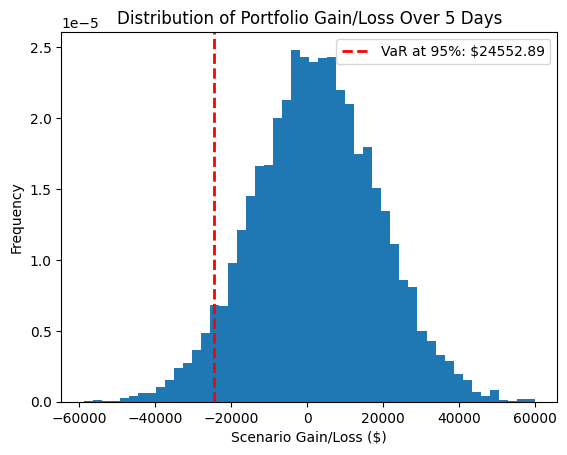

In [24]:
var_simulator = VaRMonteCarlo(days=5, confidence_level=0.95, price_df=price_df)
print(f'VaR: {var_simulator.get_VaR()}')
var_simulator.plot_distribution()